# Medical Image Fusion using DWT and PCA
This notebook demonstrates medical image fusion using Discrete Wavelet Transform (DWT) and Principal Component Analysis (PCA) on real MRI and CT images from the provided dataset.

In [1]:
# Section 1: Import Required Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import pywt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import os
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Section 2: Define MedicalImageFusion Class
class MedicalImageFusion:
    def __init__(self):
        self.wavelet = 'db4'  # Daubechies wavelet
        self.mode = 'symmetric'
        
    def load_and_preprocess_images(self, mri_path, ct_path):
        mri_img = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
        ct_img = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
        if mri_img is None or ct_img is None:
            raise ValueError("Could not load one or both images. Check file paths.")
        if mri_img.shape != ct_img.shape:
            h = min(mri_img.shape[0], ct_img.shape[0])
            w = min(mri_img.shape[1], ct_img.shape[1])
            mri_img = cv2.resize(mri_img, (w, h))
            ct_img = cv2.resize(ct_img, (w, h))
        # Crop to nearest multiple of 4 for both dimensions
        h, w = mri_img.shape
        h4, w4 = h - (h % 4), w - (w % 4)
        mri_img = mri_img[:h4, :w4]
        ct_img = ct_img[:h4, :w4]
        mri_img = mri_img.astype(np.float64) / 255.0
        ct_img = ct_img.astype(np.float64) / 255.0
        return mri_img, ct_img
    def dwt_decomposition(self, image):
        coeffs1 = pywt.dwt2(image, self.wavelet, mode=self.mode)
        cA1, (cH1, cV1, cD1) = coeffs1
        coeffs2 = pywt.dwt2(cA1, self.wavelet, mode=self.mode)
        cA2, (cH2, cV2, cD2) = coeffs2
        return {
            'cA2': cA2,
            'cH2': cH2, 'cV2': cV2, 'cD2': cD2,
            'cH1': cH1, 'cV1': cV1, 'cD1': cD1
        }
    def principal_component_averaging(self, coeffs1, coeffs2, block_size=8):
        if coeffs1.shape != coeffs2.shape:
            min_h = min(coeffs1.shape[0], coeffs2.shape[0])
            min_w = min(coeffs1.shape[1], coeffs2.shape[1])
            coeffs1 = coeffs1[:min_h, :min_w]
            coeffs2 = coeffs2[:min_h, :min_w]
        h, w = coeffs1.shape
        fused_coeffs = np.zeros_like(coeffs1)
        for i in range(0, h - block_size + 1, block_size):
            for j in range(0, w - block_size + 1, block_size):
                block1 = coeffs1[i:i+block_size, j:j+block_size]
                block2 = coeffs2[i:i+block_size, j:j+block_size]
                data = np.column_stack([block1.flatten(), block2.flatten()])
                try:
                    pca = PCA(n_components=2)
                    pca_result = pca.fit_transform(data)
                    eigenvals = pca.explained_variance_
                    if len(eigenvals) >= 2:
                        w1 = eigenvals[0] / (eigenvals[0] + eigenvals[1])
                        w2 = eigenvals[1] / (eigenvals[0] + eigenvals[1])
                    else:
                        w1, w2 = 0.5, 0.5
                    fused_block = w1 * block1 + w2 * block2
                except:
                    fused_block = 0.5 * (block1 + block2)
                fused_coeffs[i:i+block_size, j:j+block_size] = fused_block
        if h % block_size != 0 or w % block_size != 0:
            remaining_h = h - (h // block_size) * block_size
            remaining_w = w - (w // block_size) * block_size
            if remaining_h > 0:
                fused_coeffs[-remaining_h:, :] = 0.5 * (
                    coeffs1[-remaining_h:, :] + coeffs2[-remaining_h:, :]
                )
            if remaining_w > 0:
                fused_coeffs[:, -remaining_w:] = 0.5 * (
                    coeffs1[:, -remaining_w:] + coeffs2[:, -remaining_w:]
                )
        return fused_coeffs
    def maximum_selection_fusion(self, coeffs1, coeffs2):
        if coeffs1.shape != coeffs2.shape:
            min_h = min(coeffs1.shape[0], coeffs2.shape[0])
            min_w = min(coeffs1.shape[1], coeffs2.shape[1])
            coeffs1 = coeffs1[:min_h, :min_w]
            coeffs2 = coeffs2[:min_h, :min_w]
        mask = np.abs(coeffs1) >= np.abs(coeffs2)
        fused_coeffs = np.where(mask, coeffs1, coeffs2)
        return fused_coeffs
    def fuse_images(self, mri_img, ct_img):
        mri_coeffs = self.dwt_decomposition(mri_img)
        ct_coeffs = self.dwt_decomposition(ct_img)
        fused_cA2 = self.principal_component_averaging(
            mri_coeffs['cA2'], ct_coeffs['cA2']
        )
        fused_cH2 = self.maximum_selection_fusion(
            mri_coeffs['cH2'], ct_coeffs['cH2']
        )
        fused_cV2 = self.maximum_selection_fusion(
            mri_coeffs['cV2'], ct_coeffs['cV2']
        )
        fused_cD2 = self.maximum_selection_fusion(
            mri_coeffs['cD2'], ct_coeffs['cD2']
        )
        fused_cH1 = self.maximum_selection_fusion(
            mri_coeffs['cH1'], ct_coeffs['cH1']
        )
        fused_cV1 = self.maximum_selection_fusion(
            mri_coeffs['cV1'], ct_coeffs['cV1']
        )
        fused_cD1 = self.maximum_selection_fusion(
            mri_coeffs['cD1'], ct_coeffs['cD1']
        )
        coeffs_level2 = (fused_cA2, (fused_cH2, fused_cV2, fused_cD2))
        reconstructed_cA1 = pywt.idwt2(coeffs_level2, self.wavelet, mode=self.mode)
        
        # Ensure all level 1 coefficients have the same size
        target_h, target_w = fused_cH1.shape
        if reconstructed_cA1.shape != (target_h, target_w):
            reconstructed_cA1 = cv2.resize(reconstructed_cA1, (target_w, target_h))
        
        coeffs_level1 = (reconstructed_cA1, (fused_cH1, fused_cV1, fused_cD1))
        fused_image = pywt.idwt2(coeffs_level1, self.wavelet, mode=self.mode)
        fused_image = np.clip(fused_image, 0, 1)
        
        # Check for NaN or inf values
        if np.any(np.isnan(fused_image)) or np.any(np.isinf(fused_image)):
            print("Warning: Fused image contains NaN or inf values. Using simple averaging fallback.")
            fused_image = 0.5 * (mri_img + ct_img)
            fused_image = np.clip(fused_image, 0, 1)
        
        return fused_image
    def calculate_metrics(self, img1, img2, fused_img):
        metrics = {}
        
        # Check for NaN values in input images
        if np.any(np.isnan(img1)) or np.any(np.isnan(img2)) or np.any(np.isnan(fused_img)):
            print("Warning: Input images contain NaN values")
            return {metric: np.nan for metric in ['PSNR', 'SSIM', 'MSE', 'SD', 'SNR', 'Correlation', 'NCC', 'MD', 'NAE']}
        
        try:
            # MSE
            mse_val = np.mean((img1 - fused_img) ** 2)
            metrics['MSE'] = mse_val
            
            # PSNR
            if mse_val == 0:
                metrics['PSNR'] = float('inf')
            else:
                metrics['PSNR'] = 20 * np.log10(1.0 / np.sqrt(mse_val))
            
            # SSIM
            metrics['SSIM'] = ssim(img1, fused_img, data_range=1.0)
            
            # Standard Deviation
            metrics['SD'] = np.std(fused_img)
            
            # Signal to Noise Ratio
            signal_power = np.mean(fused_img ** 2)
            if mse_val == 0:
                metrics['SNR'] = float('inf')
            else:
                metrics['SNR'] = 10 * np.log10(signal_power / mse_val) if mse_val > 0 else float('inf')
            
            # Correlation
            correlation_matrix = np.corrcoef(img1.flatten(), fused_img.flatten())
            metrics['Correlation'] = correlation_matrix[0, 1] if not np.isnan(correlation_matrix[0, 1]) else 0.0
            
            # Normalized Cross Correlation
            ncc_num = np.sum(img1 * fused_img)
            ncc_den = np.sqrt(np.sum(img1 ** 2) * np.sum(fused_img ** 2))
            metrics['NCC'] = ncc_num / ncc_den if ncc_den != 0 else 0.0
            
            # Maximum Difference
            metrics['MD'] = np.max(np.abs(img1 - fused_img))
            
            # Normalized Absolute Error
            nae_num = np.sum(np.abs(img1 - fused_img))
            nae_den = np.sum(np.abs(img1))
            metrics['NAE'] = nae_num / nae_den if nae_den != 0 else 0.0
            
        except Exception as e:
            print(f"Error calculating metrics: {e}")
            metrics = {metric: np.nan for metric in ['PSNR', 'SSIM', 'MSE', 'SD', 'SNR', 'Correlation', 'NCC', 'MD', 'NAE']}
        
        return metrics
    def visualize_results(self, mri_img, ct_img, fused_img, metrics):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(mri_img, cmap='gray')
        plt.title('MRI Image')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(ct_img, cmap='gray')
        plt.title('CT Image')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(fused_img, cmap='gray')
        plt.title('Fused Image')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("\nFusion Performance Metrics:")
        print("-" * 40)
        for metric, value in metrics.items():
            if isinstance(value, float) and not np.isnan(value):
                if value == float('inf'):
                    print(f"{metric}: inf")
                else:
                    print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")

In [3]:
# Section 3: List and Select MRI and CT Images from Dataset
# Set dataset root directory
ct_dir = '../Dataset/CT-MRI/CT'
mri_dir = '../Dataset/CT-MRI/MRI'

# List available CT and MRI image files
ct_files = sorted([f for f in os.listdir(ct_dir) if f.endswith('.png')])
mri_files = sorted([f for f in os.listdir(mri_dir) if f.endswith('.png')])

print('Available CT files:', len(ct_files))
print('Available MRI files:', len(mri_files))

# Find paired images (same filename in both directories)
paired_files = list(set(ct_files) & set(mri_files))
paired_files.sort()

print(f'Found {len(paired_files)} paired images')
print('Sample paired files:', paired_files[:5])

# Select image pair (change index as needed)
image_idx = 0  # Change this index to select a different image pair
selected_file = paired_files[image_idx]

ct_path = os.path.join(ct_dir, selected_file)
mri_path = os.path.join(mri_dir, selected_file)

print('Selected CT:', ct_path)
print('Selected MRI:', mri_path)

# Check if files exist
if not os.path.exists(ct_path):
    print(f"CT file not found: {ct_path}")
if not os.path.exists(mri_path):
    print(f"MRI file not found: {mri_path}")

Available CT files: 573
Available MRI files: 573
Found 573 paired images
Sample paired files: ['16003.png', '16004.png', '16005.png', '16006.png', '16007.png']
Selected CT: ../Dataset/CT-MRI/CT/16003.png
Selected MRI: ../Dataset/CT-MRI/MRI/16003.png


In [4]:
# Section 4: Load and Preprocess Selected Images
fusion = MedicalImageFusion()

# Load and preprocess images
mri_img, ct_img = fusion.load_and_preprocess_images(mri_path, ct_path)

print('MRI image shape:', mri_img.shape)
print('CT image shape:', ct_img.shape)

MRI image shape: (256, 256)
CT image shape: (256, 256)


In [5]:
# Section 5: Perform Image Fusion
fused_img = fusion.fuse_images(mri_img, ct_img)
print('Fused image shape:', fused_img.shape)

Fused image shape: (256, 256)


In [6]:
# Section 6: Calculate Fusion Performance Metrics
metrics = fusion.calculate_metrics(mri_img, ct_img, fused_img)
print('Fusion metrics:', metrics)

Fusion metrics: {'MSE': np.float64(0.027784849150003902), 'PSNR': np.float64(15.561919567515098), 'SSIM': np.float64(0.6657654721851446), 'SD': np.float64(0.1870902312928581), 'SNR': np.float64(2.7481974094752077), 'Correlation': np.float64(0.5454889684161435), 'NCC': np.float64(0.6899949725540644), 'MD': np.float64(0.5), 'NAE': np.float64(0.88961383236072)}


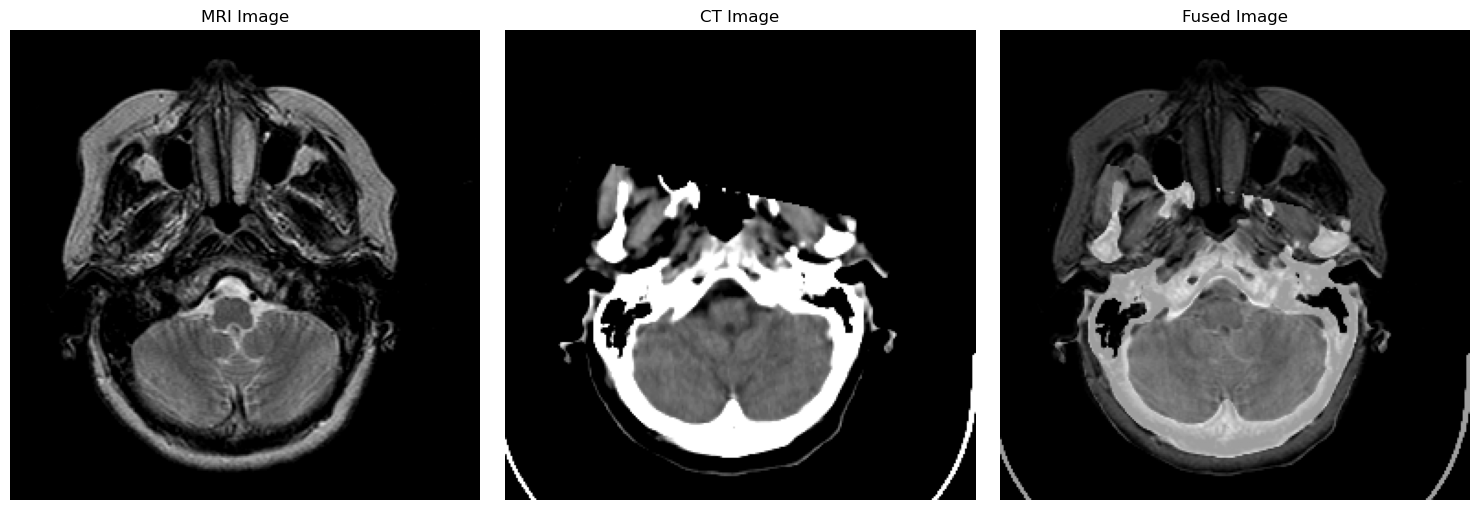


Fusion Performance Metrics:
----------------------------------------
MSE: 0.0278
PSNR: 15.5619
SSIM: 0.6658
SD: 0.1871
SNR: 2.7482
Correlation: 0.5455
NCC: 0.6900
MD: 0.5000
NAE: 0.8896


In [7]:
# Section 7: Visualize Fusion Results
fusion.visualize_results(mri_img, ct_img, fused_img, metrics)

In [8]:
# Section 8: Save Fused Image
# Create results directory if it doesn't exist
results_dir = 'results/dwt_pca'
os.makedirs(results_dir, exist_ok=True)

# Save with method name and image filename
base_filename = os.path.splitext(selected_file)[0]
save_path = os.path.join(results_dir, f'fused_image_dwt_pca_{base_filename}.png')
cv2.imwrite(save_path, (fused_img * 255).astype(np.uint8))
print(f'Fused image saved as {save_path}')

# Also save metrics to a text file
metrics_file = os.path.join(results_dir, f'metrics_dwt_pca_{base_filename}.txt')
with open(metrics_file, 'w') as f:
    f.write(f"Fusion Metrics for {selected_file}\n")
    f.write("=" * 40 + "\n")
    for metric, value in metrics.items():
        if isinstance(value, float) and not np.isnan(value):
            if value == float('inf'):
                f.write(f"{metric}: inf\n")
            else:
                f.write(f"{metric}: {value:.4f}\n")
        else:
            f.write(f"{metric}: {value}\n")
print(f'Metrics saved as {metrics_file}')

Fused image saved as results/dwt_pca/fused_image_dwt_pca_16003.png
Metrics saved as results/dwt_pca/metrics_dwt_pca_16003.txt
